<a href="https://colab.research.google.com/github/dldowning/Fall2022-5222/blob/main/SentimentAnalysis_FeatureResearch-DowningRoberts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Setup

## Imports - Installations

In [1]:
%pip install emoji
%pip install shap
import pandas as pd
import numpy as np
from statistics import mean
import nltk
from google.colab import files
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import math
import requests
import string
import random
from nltk.corpus import stopwords
import csv
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import re
import emoji
import plotly.graph_objects as go
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier #for binary classification
import xgboost as xgb #for probability classification
from xgboost import plot_importance
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from matplotlib import pyplot
import shap
import plotly.express as px
from sklearn import metrics  
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
from sklearn.inspection import partial_dependence

In [3]:
from sklearn.inspection import PartialDependenceDisplay

## Create & Edit Dataframes

**Import Data**

In [4]:
!gdown 1ubIaCqJnOzG-m_ns7VmdV87Ecs349BbG

Downloading...
From: https://drive.google.com/uc?id=1ubIaCqJnOzG-m_ns7VmdV87Ecs349BbG
To: /content/tweets_extracted.csv
100% 18.3M/18.3M [00:00<00:00, 79.7MB/s]


In [5]:
URL = "https://drive.google.com/uc?export=download&id=1C8ARH_yok3uOvirD_oKvgEmAR22SuC9R"
response = requests.get(URL)
open("train_text_labels.csv", "wb").write(response.content)

URL = "https://drive.google.com/uc?export=download&id=1z0URnDJ8ck38mQ4CvHi5TUkly8e46glP"
response = requests.get(URL)
open("test_text.txt", "wb").write(response.content)

URL = "https://drive.google.com/uc?export=download&id=1xWQ2Lpf866Be4OR8J-cJHuY1S25dWppf"
response = requests.get(URL)
open("test_labels.txt", "wb").write(response.content)

36850

**Train Dataframe**

In [6]:
df_train = pd.read_csv("/content/train_text_labels.csv", header=None)
df_train.columns = ['Tweet', 'Label']

#populated with Undedited Tweets and labels 0,1,& 2
df_train

,Tweet,Label
0,QT @user In the original draft of the 7th book...,2
1,Ben Smith / Smith (concussion) remains out of ...,1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2
...,...,...
45610,"@user \""""So amazing to have the beautiful Lady...",2
45611,"9 September has arrived, which means Apple's n...",2
45612,Leeds 1-1 Sheff Wed. Giuseppe Bellusci securin...,2
45613,@user no I'm in hilton head till the 8th lol g...,1


**Test Dataframe**

In [7]:
df_test = pd.read_fwf("/content/test_text.txt", header=None)
df_test.columns = ['Tweet']

#populated with unedited tweets with no labels
df_test

,Tweet
0,@user @user what do these '1/2 naked pics' hav...
1,OH: “I had a blue penis while I was this” [pla...
2,"@user @user That's coming, but I think the vic..."
3,I think I may be finally in with the in crowd ...
4,"@user Wow,first Hugo Chavez and now Fidel Cast..."
...,...
12279,Sentinel Editorial: FBI’s Comey ‘had no one of...
12280,perfect pussy clips #vanessa hudgens zac efron...
12281,#latestnews 4 #newmexico #politics + #nativeam...
12282,Trying to have a conversation with my dad abou...


In [8]:
# dataframe of labels for test inputs - This is the only operation df_testLabels is used for
df_testLabels = pd.read_fwf("/content/test_labels.txt", header = None)
df_testLabels

,0
0,1
1,1
2,1
3,2
4,0
...,...
12279,1
12280,1
12281,1
12282,0


In [9]:
#Concatenate df_test which holds the test tweets and df_testlabels so that the test tweets have their associated labels 
horizontal_concat = pd.concat([df_test, df_testLabels], axis=1)
horizontal_concat.rename(columns={0: 'Label'}, inplace=True)
df_test = horizontal_concat
df_test

,Tweet,Label
0,@user @user what do these '1/2 naked pics' hav...,1
1,OH: “I had a blue penis while I was this” [pla...,1
2,"@user @user That's coming, but I think the vic...",1
3,I think I may be finally in with the in crowd ...,2
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",0
...,...,...
12279,Sentinel Editorial: FBI’s Comey ‘had no one of...,1
12280,perfect pussy clips #vanessa hudgens zac efron...,1
12281,#latestnews 4 #newmexico #politics + #nativeam...,1
12282,Trying to have a conversation with my dad abou...,0


**Dataframe Info**

In [10]:
df_train['Label'].value_counts()
#0	negative
#1	neutral
#2	positive

1    20673
2    17849
0     7093
Name: Label, dtype: int64

**Drop Neutral Values from Train & Test Dataframe**

We are dropping the neutral values because our classification task is concerned with only positive and negative classifications 

In [11]:
#Our data frame will be equal to only the inputs with a labels value not equal to 1 (neutral)
df_train = df_train[df_train['Label'] != 1]

#In our dataframe, all values that equal two are replaced by value, 1
df_train.loc[df_train.Label == 2, 'Label'] = 1

#reset the index 
df_train=df_train.reset_index(drop=True)


In [12]:
#We now have a dataframe with only values 0 & 1
#0- Negative 
#1- Positive
df_train.head()

,Tweet,Label
0,QT @user In the original draft of the 7th book...,1
1,@user Alciato: Bee will invest 150 million in ...,1
2,@user LIT MY MUM 'Kerry the louboutins I wonde...,1
3,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ...",1
4,So disappointed in wwe summerslam! I want to s...,0


In [13]:
#Do the same for the test data
df_test = df_test[df_test['Label'] != 1]
df_test.loc[df_test.Label == 2, 'Label'] = 1
df_test = df_test.reset_index(drop=True)


In [14]:
df_test.head()

,Tweet,Label
0,I think I may be finally in with the in crowd ...,1
1,"@user Wow,first Hugo Chavez and now Fidel Cast...",0
2,Twitter's #ThankYouObama Shows Heartfelt Grati...,1
3,@user @user @user @user @user @user take away ...,0
4,#onedirection #harrystyles cute little dance 😉,1


In [15]:
#Drop the labels from the test datframe because in order to test we cant have the actual outcome attatched
df_test = df_test.drop(columns=['Label'])
df_test.head()

,Tweet
0,I think I may be finally in with the in crowd ...
1,"@user Wow,first Hugo Chavez and now Fidel Cast..."
2,Twitter's #ThankYouObama Shows Heartfelt Grati...
3,@user @user @user @user @user @user take away ...
4,#onedirection #harrystyles cute little dance 😉


**Save Original Unedited Tweets for additional feature extraction info**

In [16]:
#We are saving the original unedited tweets before they are cleaned and tokenized becuse we need the oriinal tweets as part of our feature extraction later
train_original_Tweets = df_train[['Tweet']].copy()
test_original_Tweets = df_test[['Tweet']].copy()

## Clean & Tokenize Tweets

**Clean Tweet Function**

In [17]:
def tweetcleanandtoke(dataframe,colname,newcolname):
  stop = stopwords.words('english')
  pattern_a = r'[^A-Za-z0-9]+' #non-alphanumeric
  pattern_b = r'\b\w{1,1}\b' #repeated words
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)

  for i in range(0, len(dataframe.index)):                       
    dataframe[colname].values[i] = dataframe[colname].values[i].lower()
    dataframe[colname].values[i] = dataframe[colname].values[i].replace('@user', '')
    dataframe[colname].values[i] = re.sub(emoji_pattern, '', dataframe[colname].values[i])
    dataframe[colname].values[i] = re.sub(pattern_a, ' ', dataframe[colname].values[i])
    dataframe[colname].values[i] = re.sub(pattern_b, '', dataframe[colname].values[i])
    

  dataframe[colname] = dataframe[colname].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  rowname = dataframe[colname].name
  dataframe[newcolname]=0
  dataframe[newcolname] = dataframe.apply(lambda row: nltk.word_tokenize(row[rowname]), axis=1)

  return dataframe

**Cleaned Tweet Info**

In [18]:
df_train=tweetcleanandtoke(df_train,'Tweet','Twitter_tokens')
df_test=tweetcleanandtoke(df_test,'Tweet','Twitter_tokens')

In [19]:
#Get Length of list of tokens for each tweet
df_train['Token_len']=df_train['Twitter_tokens'].apply(len)
df_test['Token_len']=df_test['Twitter_tokens'].apply(len)

In [20]:
#Evaluating the tokens for some EDA, also verifying I have no length 0
list_of_lengths=[]
less_than_9_len=[]
for i in range (0, len(df_train)):
  try:
    list_of_lengths.append(len(df_train['Twitter_tokens'][i]));
  except:
    pass
  try:
    if len(df_train['Twitter_tokens'][i]) < 9:
      less_than_9_len.append(str(i));
  except:
    pass
print("These stats are for the training set")
print("The min length is: " + str(min(list_of_lengths)))
print("The max length is: " + str(max(list_of_lengths)))
print("The mean length is: " + str(mean(list_of_lengths)))
print("The number of tweets with less than 9 tokens is: " + str(len(less_than_9_len)))

These stats are for the training set
The min length is: 1
The max length is: 26
The mean length is: 11.502004650789832
The number of tweets with less than 9 tokens is: 4506


In [21]:
list_of_lengths=[]
less_than_9_len=[]
for i in range (0, len(df_test)):
  try:
    list_of_lengths.append(len(df_test['Twitter_tokens'][i]));
  except:
    pass
  try:
    if len(df_test['Twitter_tokens'][i]) < 9:
      less_than_9_len.append(str(i));
  except:
    pass
print("These stats are for the testing set")
print("The min test length is: " + str(min(list_of_lengths)))
print("The max test length is: " + str(max(list_of_lengths)))
print("The mean test length is: " + str(mean(list_of_lengths)))
print("The number of test tweets with less than 9 tokens is: " + str(len(less_than_9_len)))

These stats are for the testing set
The min test length is: 1
The max test length is: 20
The mean test length is: 9.237277453915235
The number of test tweets with less than 9 tokens is: 2587


## Load and Extract Tsv Files Required for Data Input and Model Training
Here we are importing the words with their assigned sentiment scores from our data sources these scores are aggregated and used as tabular features in our model

In [22]:
#Here we are downloading the data for senttiment scores for words so we have a hueristic measure for if a word is good or bad
#words from this list have a positive or negative score attatched to them
!wget https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_freq.zip
!echo "N"| unzip /content/socialsent_hist_freq.zip

!wget https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_adj.zip
!echo "N"| unzip /content/socialsent_hist_adj.zip

--2023-04-14 04:28:55--  https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_freq.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 521987 (510K) [application/zip]
Saving to: ‘socialsent_hist_freq.zip.1’

socialsent_hist_fre 100%[===================>] 509.75K   262KB/s    in 1.9s    

2023-04-14 04:28:58 (262 KB/s) - ‘socialsent_hist_freq.zip.1’ saved [521987/521987]

Archive:  /content/socialsent_hist_freq.zip
replace frequent_words/1850.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: --2023-04-14 04:28:58--  https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_adj.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201855 (197K) [application/zip]
Saving to: 

In [23]:
df_2000adj = pd.read_csv("/content/adjectives/2000.tsv", sep="\t", header=None)
df_2000adj.columns = ['Word', 'Sentiment', 'Std']
df_2000freq = pd.read_csv("/content/frequent_words/2000.tsv", sep="\t", header=None)
df_2000freq.columns = ['Word', 'Sentiment', 'Std']

In [24]:
df_2000freq.head()

,Word,Sentiment,Std
0,ugly,-3.90,1.16
1,painful,-3.69,1.53
2,intent,-3.49,1.67
3,terrible,-3.38,1.55
4,drunk,-3.28,1.16


In [25]:
# Downloading a group of files formatted like the previous. 
# Each of these subreddit files has an attatched score for if the word is used poitivley or negativley in the context of the given subbreddit
!wget https://nlp.stanford.edu/projects/socialsent/files/socialsent_subreddits.zip
!echo "N"| unzip /content/socialsent_subreddits.zip

--2023-04-14 04:29:00--  https://nlp.stanford.edu/projects/socialsent/files/socialsent_subreddits.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15659374 (15M) [application/zip]
Saving to: ‘socialsent_subreddits.zip.1’

socialsent_subreddi 100%[===================>]  14.93M  3.73MB/s    in 7.2s    

2023-04-14 04:29:08 (2.09 MB/s) - ‘socialsent_subreddits.zip.1’ saved [15659374/15659374]

Archive:  /content/socialsent_subreddits.zip
replace subreddits/.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [26]:
#We have a preselected list of files from the zip folder that we want to use. 
list_files = ['3DS.tsv', 
'4chan.tsv',
'2007scape.tsv',
'ACTrade.tsv',
'amiugly.tsv',
'BabyBumps.tsv',
'baseball.tsv',
'canada.tsv',
'CasualConversation.tsv',
'DarkNetMarkets.tsv',
'darksouls.tsv',
'elderscrollsonline.tsv',
'Eve.tsv',
'Fallout.tsv',
'fantasyfootball.tsv',
'GameDeals.tsv',
'gamegrumps.tsv',
'halo.tsv',
'Homebrewing.tsv',
'IAmA.tsv',
'india.tsv',
'jailbreak.tsv',
'Jokes.tsv',
'KerbalSpaceProgram.tsv',
'keto.tsv',
'leagueoflegends.tsv',
'Libertarian.tsv',
'magicTCG.tsv',
'MakeupAddiction.tsv',
'Naruto.tsv',
'nba.tsv',
'oculus.tsv',
'OkCupid.tsv',
'Parenting.tsv',
'pathofexile.tsv',
'raisedbynarcissists.tsv',
'Random_Acts_Of_Amazon.tsv',
'science.tsv',
'Seattle.tsv',
'TalesFromRetail.tsv',
'talesfromtechsupport.tsv',
'ultrahardcore.tsv',
'videos.tsv',
'Warthunder.tsv',
'whowouldwin.tsv',
'xboxone.tsv',
'yugioh.tsv',
]

In [27]:
# In this function each of our preselected files from the list above is 
# turned into a dataframe and then converted to a dictionary. Each of these dictionaries is then appended to a lsit 
# thus creating a list of dictionaries, the length of our list. 
list_dicts=[]
for i in range(0,len(list_files)):
    dfname='df_'+str(list_files[i])
    dfname=dfname.replace('.tsv','')
    path="/content/subreddits/" + list_files[i]
    dataframe = pd.read_csv(path, sep="\t", header=None)
    dataframe.columns = ['Word', 'Sentiment', 'Std']
    dataframe=dataframe.drop(columns=['Std'])
    list_dicts.append(dict(dataframe.values))

In [28]:
#This function is used to merge two dictionaries into one 
def dict_merger(dict1, dict2):
    new_dict = {**dict1, **dict2}
    return new_dict


In [29]:
#Drop std column from the first two data sources that contain word scores 
df_2000adj=df_2000adj.drop(columns='Std')
feature1=dict(df_2000adj.values)
df_2000freq=df_2000freq.drop(columns='Std')
feature2=dict(df_2000freq.values)

In [30]:
#we are creating a dictionary starting at feature number 3 because the firt two features are soley dependent upon the first two data sources
# the two we just edited above 

#The "Feature 3" is a merger of dictionaries 0-8. (The dictionaries from list_dict)
feature3 = {}
for i in range(0, 8):
  feature3=dict_merger(feature3,list_dicts[i])

#The "Feature 4" is a merger of dictionaries 8-16. (The dictionaries from list_dict)
feature4 = {}
for i in range(8, 16):
  feature4=dict_merger(feature4,list_dicts[i])

feature5 = {}
for i in range(16, 23):
  feature5=dict_merger(feature5,list_dicts[i])

feature6 = {}
for i in range(23, 29):
  feature6=dict_merger(feature6,list_dicts[i])

feature7 = {}
for i in range(29, 34):
  feature7=dict_merger(feature7,list_dicts[i])

feature8 = {}
for i in range(34, 41):
  feature8=dict_merger(feature8,list_dicts[i])

feature9 = {}
for i in range(41, 47):
  feature9=dict_merger(feature9,list_dicts[i])

# Feature Extraction: Features 1-12

## **Define** function for extracting features 1-9


In [31]:
#This function looks up if a random of 9 words from the given tweet is in the dictionary currently being looked through,
# If it is, we sum the score.

def lookups_train(row):
  lookup_index=row.name
  #print("This is the lookup_index: " + str(lookup_index))
  range_len=(df_train['Token_len'][lookup_index])
  #print("This is the range_len: " + str(range_len))
  score=[]
  for i in range(0, 9):
    #print("Starting the for loop at: " + str(i))
    token=random.randint(0, range_len) 
    token -= 1
    #print("The token is: " + str(token))
    word_tok=df_train.iloc[lookup_index, 2][token]
    #print("The word_tok is: " + str(word_tok))
    try:
      score.append(current_dict[word_tok])
    except:
      pass
  try:
      sum_score=sum(score)
  except:
      sum_score=0
  return sum_score

def lookups_test(row):
  lookup_index=row.name
  #print("This is the lookup_index: " + str(lookup_index))
  range_len=(df_test['Token_len'][lookup_index])
  #print("This is the range_len: " + str(range_len))
  score=[]
  for i in range(0, 9):
    #print("Starting the for loop at: " + str(i))
    token=random.randint(0, range_len) 
    token -= 1
    #print("The token is: " + str(token))
    word_tok=df_test.iloc[lookup_index, 1][token]
    #print("The word_tok is: " + str(word_tok))
    try:
      score.append(current_dict[word_tok])
    except:
      pass
  try:
      sum_score=sum(score)
  except:
      sum_score=0
  return sum_score

## **Define** functions for getting feature 11 & 12 for training data

In [32]:
# Takes log value of longest word in given training tweet
def wordlengther_train(row):
    index=row.name
    token_list=df_train['Twitter_tokens'][index]
    longest_word=1
    for word in token_list:
        if longest_word<len(word):
          longest_word=len(word)
    log_long=np.log10(longest_word)
    return log_long

# Counts words longer than 5 characters in a given training tweet
def wordfiver_train(row):
    index=row.name
    token_list=df_train['Twitter_tokens'][index]
    five_counts=1
    for word in token_list:
        if len(word)>=5:
          five_counts+=1
    log_five=np.log10(five_counts)
    return log_five

## **Define** functions for getting feature 11 & 12 for test data

In [33]:
# Takes log value of longest word in given test tweet
def wordlengther_test(row):
    index=row.name
    token_list=df_test['Twitter_tokens'][index]
    longest_word=1
    for word in token_list:
        if longest_word<len(word):
          longest_word=len(word)
    log_long=np.log10(longest_word)
    return log_long

# Counts words longer than 5 characters in a given test tweet
def wordfiver_test(row):
    index=row.name
    token_list=df_test['Twitter_tokens'][index]
    five_counts=1
    for word in token_list:
        if len(word)>=5:
          five_counts+=1
    log_five=np.log10(five_counts)
    return log_five


##  **Define** function for creating a list of words that are seen in two different lists

In [34]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

## **Create** empty colums to hold feature values

In [35]:
#Create colums to hold values of feature calulations - train 
df_train['feature1']=0
df_train['feature2']=0
df_train['feature3']=0
df_train['feature4']=0
df_train['feature5']=0
df_train['feature6']=0
df_train['feature7']=0
df_train['feature8']=0
df_train['feature9']=0
df_train['feature10']=0
df_train['feature11']=0
df_train['feature12']=0

In [36]:
#Create colums to hold values of feature calulations - test
df_test['feature1']=0
df_test['feature2']=0
df_test['feature3']=0
df_test['feature4']=0
df_test['feature5']=0
df_test['feature6']=0
df_test['feature7']=0
df_test['feature8']=0
df_test['feature9']=0
df_test['feature10']=0
df_test['feature11']=0
df_test['feature12']=0

## **Execute** the functions to populate feature columns 1-9 (train & test)

In [37]:
features_list=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9']
for i in range(0, len(features_list)):
  current_dict=list_dicts[i]
  df_train[features_list[i]]=df_train.apply(lookups_train, axis=1)
  df_test[features_list[i]]=df_test.apply(lookups_test, axis=1)

In [38]:
df_train

,Tweet,Label,Twitter_tokens,Token_len,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
0,qt original draft 7th book remus lupin survive...,1,"[qt, original, draft, 7th, book, remus, lupin,...",11,1.42,1.66,0.60,-1.04,0.00,0.42,1.78,3.83,-0.08,0,0,0
1,alciato bee invest 150 million january another...,1,"[alciato, bee, invest, 150, million, january, ...",13,3.42,-1.27,-1.18,0.84,0.51,0.12,-1.12,-1.78,-0.14,0,0,0
2,lit mum kerry louboutins wonder many willam ow...,1,"[lit, mum, kerry, louboutins, wonder, many, wi...",12,2.38,3.72,-9.51,-0.09,-2.13,0.88,1.17,-4.75,-1.33,0,0,0
3,soul train oct 27 halloween special ft dot fin...,1,"[soul, train, oct, 27, halloween, special, ft,...",21,0.73,0.78,8.53,1.99,0.30,1.37,4.35,6.98,2.17,0,0,0
4,disappointed wwe summerslam want see john cena...,0,"[disappointed, wwe, summerslam, want, see, joh...",10,3.60,2.73,-1.18,-1.48,-0.45,6.30,0.69,0.75,1.14,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24937,michael good times 2nd greatest michael michae...,1,"[michael, good, times, 2nd, greatest, michael,...",10,5.16,0.34,-2.62,3.40,-3.62,5.42,-0.57,-2.56,5.48,0,0,0
24938,think misguided girl vip tonight suckin dick w...,0,"[think, misguided, girl, vip, tonight, suckin,...",14,2.50,3.23,-1.41,0.92,-1.72,-1.63,-2.03,-1.97,-0.95,0,0,0
24939,amazing beautiful lady gaga show ac tonight lo...,1,"[amazing, beautiful, lady, gaga, show, ac, ton...",10,4.52,-3.08,1.50,5.64,8.91,6.72,4.66,11.75,0.60,0,0,0
24940,september arrived means apple new iphone hours...,1,"[september, arrived, means, apple, new, iphone...",11,4.49,9.73,-3.33,4.64,0.23,-2.51,-0.30,-4.60,2.10,0,0,0


In [39]:
df_test

,Tweet,Twitter_tokens,Token_len,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
0,think may finally crowd mannequinchallenge gra...,"[think, may, finally, crowd, mannequinchalleng...",6,2.76,6.20,2.76,4.66,0.05,-0.87,3.93,-1.89,1.08,0,0,0
1,wow first hugo chavez fidel castro danny glove...,"[wow, first, hugo, chavez, fidel, castro, dann...",16,2.12,-0.17,0.24,3.58,0.24,1.62,4.07,-0.77,2.29,0,0,0
2,twitter thankyouobama shows heartfelt gratitud...,"[twitter, thankyouobama, shows, heartfelt, gra...",6,-0.84,0.63,0.32,-0.29,-0.28,0.83,0.19,7.82,0.93,0,0,0
3,take away illegals dead people trump wins popu...,"[take, away, illegals, dead, people, trump, wi...",9,-0.21,0.69,-3.97,-0.21,-4.25,4.31,-2.99,-4.79,1.23,0,0,0
4,onedirection harrystyles cute little dance,"[onedirection, harrystyles, cute, little, dance]",5,4.81,-0.37,4.05,1.45,4.15,12.08,4.79,0.03,2.62,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6342,al crying middle america left twice much votin...,"[al, crying, middle, america, left, twice, muc...",9,-1.79,-2.69,-5.87,2.06,0.71,-0.81,-0.20,-1.51,-7.22,0,0,0
6343,even catholic pope francis dude like need hug ...,"[even, catholic, pope, francis, dude, like, ne...",11,-1.34,-6.63,4.78,4.66,1.91,3.53,1.28,-3.87,7.51,0,0,0
6344,looks like flynn pleased blocked blocked flynn,"[looks, like, flynn, pleased, blocked, blocked...",7,3.99,0.28,3.27,2.88,0.19,-1.44,2.92,0.00,2.09,0,0,0
6345,trying conversation dad vegetarianism pointles...,"[trying, conversation, dad, vegetarianism, poi...",9,0.20,-0.84,-7.04,-1.45,-0.58,-0.68,-0.44,-0.48,1.48,0,0,0


## **Execute** Functions to populate features 10-12

In [40]:
#features 1-9 have been populated now we have to pupulate 10-12 with the functions that we defined earlier

#log value feature
df_train['feature10'] = df_train['Token_len'].apply(np.log10)
df_test['feature10'] = df_test['Token_len'].apply(np.log10)

#Wordlength Function
df_train['feature11'] = df_train.apply(wordlengther_train, axis=1)
df_test['feature11'] = df_test.apply(wordlengther_test, axis=1)

#Tweet more than 5 words function
df_train['feature12'] = df_train.apply(wordfiver_train, axis=1)
df_test['feature12'] = df_test.apply(wordfiver_test, axis=1)

In [41]:
df_train

,Tweet,Label,Twitter_tokens,Token_len,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
0,qt original draft 7th book remus lupin survive...,1,"[qt, original, draft, 7th, book, remus, lupin,...",11,1.42,1.66,0.60,-1.04,0.00,0.42,1.78,3.83,-0.08,1.041393,1.361728,0.954243
1,alciato bee invest 150 million january another...,1,"[alciato, bee, invest, 150, million, january, ...",13,3.42,-1.27,-1.18,0.84,0.51,0.12,-1.12,-1.78,-0.14,1.113943,0.845098,1.000000
2,lit mum kerry louboutins wonder many willam ow...,1,"[lit, mum, kerry, louboutins, wonder, many, wi...",12,2.38,3.72,-9.51,-0.09,-2.13,0.88,1.17,-4.75,-1.33,1.079181,1.000000,0.903090
3,soul train oct 27 halloween special ft dot fin...,1,"[soul, train, oct, 27, halloween, special, ft,...",21,0.73,0.78,8.53,1.99,0.30,1.37,4.35,6.98,2.17,1.322219,0.954243,1.041393
4,disappointed wwe summerslam want see john cena...,0,"[disappointed, wwe, summerslam, want, see, joh...",10,3.60,2.73,-1.18,-1.48,-0.45,6.30,0.69,0.75,1.14,1.000000,1.079181,0.602060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24937,michael good times 2nd greatest michael michae...,1,"[michael, good, times, 2nd, greatest, michael,...",10,5.16,0.34,-2.62,3.40,-3.62,5.42,-0.57,-2.56,5.48,1.000000,0.903090,0.903090
24938,think misguided girl vip tonight suckin dick w...,0,"[think, misguided, girl, vip, tonight, suckin,...",14,2.50,3.23,-1.41,0.92,-1.72,-1.63,-2.03,-1.97,-0.95,1.146128,1.176091,0.903090
24939,amazing beautiful lady gaga show ac tonight lo...,1,"[amazing, beautiful, lady, gaga, show, ac, ton...",10,4.52,-3.08,1.50,5.64,8.91,6.72,4.66,11.75,0.60,1.000000,0.954243,0.698970
24940,september arrived means apple new iphone hours...,1,"[september, arrived, means, apple, new, iphone...",11,4.49,9.73,-3.33,4.64,0.23,-2.51,-0.30,-4.60,2.10,1.041393,0.954243,1.000000


In [42]:
df_test

,Tweet,Twitter_tokens,Token_len,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
0,think may finally crowd mannequinchallenge gra...,"[think, may, finally, crowd, mannequinchalleng...",6,2.76,6.20,2.76,4.66,0.05,-0.87,3.93,-1.89,1.08,0.778151,1.255273,0.778151
1,wow first hugo chavez fidel castro danny glove...,"[wow, first, hugo, chavez, fidel, castro, dann...",16,2.12,-0.17,0.24,3.58,0.24,1.62,4.07,-0.77,2.29,1.204120,0.845098,1.113943
2,twitter thankyouobama shows heartfelt gratitud...,"[twitter, thankyouobama, shows, heartfelt, gra...",6,-0.84,0.63,0.32,-0.29,-0.28,0.83,0.19,7.82,0.93,0.778151,1.113943,0.845098
3,take away illegals dead people trump wins popu...,"[take, away, illegals, dead, people, trump, wi...",9,-0.21,0.69,-3.97,-0.21,-4.25,4.31,-2.99,-4.79,1.23,0.954243,0.903090,0.698970
4,onedirection harrystyles cute little dance,"[onedirection, harrystyles, cute, little, dance]",5,4.81,-0.37,4.05,1.45,4.15,12.08,4.79,0.03,2.62,0.698970,1.079181,0.698970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6342,al crying middle america left twice much votin...,"[al, crying, middle, america, left, twice, muc...",9,-1.79,-2.69,-5.87,2.06,0.71,-0.81,-0.20,-1.51,-7.22,0.954243,0.845098,0.845098
6343,even catholic pope francis dude like need hug ...,"[even, catholic, pope, francis, dude, like, ne...",11,-1.34,-6.63,4.78,4.66,1.91,3.53,1.28,-3.87,7.51,1.041393,1.000000,0.602060
6344,looks like flynn pleased blocked blocked flynn,"[looks, like, flynn, pleased, blocked, blocked...",7,3.99,0.28,3.27,2.88,0.19,-1.44,2.92,0.00,2.09,0.845098,0.845098,0.845098
6345,trying conversation dad vegetarianism pointles...,"[trying, conversation, dad, vegetarianism, poi...",9,0.20,-0.84,-7.04,-1.45,-0.58,-0.68,-0.44,-0.48,1.48,0.954243,1.113943,0.903090


## Place the original unedited tweets back into the dataframe in their own column

In [43]:
# Place original unedited tweets back into the dataframe as their own column
train_original_Tweets.columns = ['Original Tweet']
df_train['Original Tweet'] = train_original_Tweets['Original Tweet']

first_column = df_train.pop('Original Tweet')
# insert column using insert(position,column_name,first_column) function
df_train.insert(0, 'Original Tweet', first_column)

In [44]:
# train_original_Tweets.columns = ['Original Tweet']
test_original_Tweets.columns = ['Original Tweet']
df_test['Original Tweet'] = test_original_Tweets['Original Tweet']

first_column = df_test.pop('Original Tweet')
# insert column using insert(position,column_name,first_column) function
df_test.insert(0, 'Original Tweet', first_column)

# Feature extraction: Features 13-34

In [45]:
# Combination of all subreddit dict values into one dict. USed in the following function
super_dict = {}
for i in range(0, len(list_dicts)):
  super_dict=dict_merger(super_dict,list_dicts[i])

## **Define** function to get feature columns 13-34 for both train and test data

In [46]:
#This function can extract feature 13-34 for both the train and test data set

def feature_extraction13_34(dataframe):  #pass in df or dft 

  dataframe["Feature 13"] = np.nan # Count: Words in + Lexicon
  dataframe["Feature 14"] = np.nan # Count: Words in - Lexicon
  dataframe["Feature 15"] = np.nan # Count: Nouns in Tweet
  dataframe["Feature 16"] = np.nan # Count: Adjectives
  dataframe["Feature 17"] = np.nan # Ratio: Unique words - total words
  dataframe["Feature 18"] = np.nan # Ratio: Stop Words - Total Words
  dataframe["Feature 19"] = np.nan # Ratio Nouns to total words
  dataframe["Feature 20"] = np.nan # Ratio of proper nouns to total words
  dataframe["Feature 21"] = np.nan # Ratio Capital letters to lowercase letters
  dataframe["Feature 22"] = np.nan # Ratio of punctuation characters to Total Characters
  dataframe["Feature 23"] = np.nan # Does Tweet conatin the word 'No'
  dataframe["Feature 24"] = np.nan # Mean Length of all words in tweet 
  dataframe["Feature 25"] = np.nan # Log of Mean Length of all words in tweet 
  dataframe["Feature 26"] = np.nan # Highest word score of all words in tweet 
  dataframe["Feature 27"] = np.nan # Lowest word score of all words in tweet
  dataframe["Feature 28"] = np.nan # Emoji count 
  dataframe["Feature 29"] = np.nan # Count: positive emojis
  dataframe["Feature 30"] = np.nan # Count: negative emojis
  dataframe["Feature 31"] = np.nan # Count: Exclamation Marks
  dataframe["Feature 32"] = np.nan # Count: Question Marks
  dataframe["Feature 33"] = np.nan # Count: First Person Pronouns
  dataframe["Feature 34"] = np.nan # Count: Third Person Pronouns




  #CREATE POSITIVE AND NEGATIVE LEXICONS
  pos_lexicon = []
  neg_lexicon = []

  for i in range(0, len(list_dicts)):               
    for j in range(0, len(list_dicts[i])):    

      if list(list_dicts[i].values())[j] >= 0:         
        pos_lexicon.append(list(list_dicts[i].keys())[j])        
          
      if list(list_dicts[i].values())[j] < 0:         
        neg_lexicon.append(list(list_dicts[i].keys())[j]) 

  pos_lexicon = [*set(pos_lexicon)]   # Remove duplicate values from + lexicon
  neg_lexicon = [*set(neg_lexicon)]   # Remove duplicate values from - lexicon

  wrds_in_PosNeg = intersection(pos_lexicon, neg_lexicon)
  wrds_in_PosNeg.pop(0)


  #Look for duplicates across dictionaries 
  duplicate_dict = {}

  for i in range(0, len(wrds_in_PosNeg)):
    sent_scores_2sum = []

    for j in range(0, len(list_dicts)):
      subreddit_wrd_list = list(list_dicts[j].keys())

      if wrds_in_PosNeg[i] in subreddit_wrd_list:
        sent_scores_2sum.append(list_dicts[j].get(wrds_in_PosNeg[i]))
        num_avg = mean(sent_scores_2sum)
    
    duplicate_dict[wrds_in_PosNeg[i]] =  num_avg

  # Remove words that now have a clear positive or negative classification
  for w in duplicate_dict.items():        # .items() returns a tuple of (word, score). See Cell above for all words: scores in dict
    if w[1] >= 0:                         # if w[1] (the score) is greater than 0...
      neg_lexicon.remove(w[0])            # remove it from the negative lexicon
    if w[1] < 0:                          # If w[1] (the score) is less than 0...
      pos_lexicon.remove(w[0])            # remove the word from the positive lexicon


  # COUNT POSITIVE AND NEGATIVE WORDS (13 & 14)
  neg_lex_set = set(neg_lexicon)
  pos_lex_set = set(pos_lexicon)

  for i in range(0, len(dataframe.index)):
    x = set(dataframe['Twitter_tokens'][i])
    dataframe['Feature 13'].values[i] = len(x.intersection(pos_lex_set))
    dataframe['Feature 14'].values[i] = len(x.intersection(neg_lex_set))


  # COUNT NOUNS IN TWEET (15)
  for i in range(0, len(dataframe.index)):
    tokens = dataframe['Twitter_tokens'][i]
    tokens = [w for w in tokens if not w in stop_words]
    tagged = nltk.pos_tag(tokens)

    noun_definitions = ['NN', 'NNS', 'NNP', 'NNPS']
    count = 0

    for j in range(0, len(tagged)):
      if tagged[j][1] in noun_definitions:
        count += 1
    
    dataframe['Feature 15'].values[i] = count  


  #COUNT ADJECTIVES IN TWEET (16)
  for i in range(0, len(dataframe.index)):
    tokens = dataframe['Twitter_tokens'][i]
    tokens = [w for w in tokens if not w in stop_words]
    tagged = nltk.pos_tag(tokens)

    adj_definitions = ['JJ', 'JJR', 'JJS ']
    count = 0

    for j in range(0, len(tagged)):
      if tagged[j][1] in adj_definitions:
        count += 1
    
    dataframe['Feature 16'].values[i] = count

  # RATIO: UNIQUE TO TOTAL WORDS (17)
  for i in range(0, len(dataframe.index)):                       
    tokens = dataframe['Twitter_tokens'][i]
    x = np.array(tokens)
    ratio = len(np.unique(x)) / len(tokens)
    dataframe['Feature 17'].values[i] = ratio


  # STOP WORDS TO TOTAL WORDS (18)
  for i in range(0, len(dataframe.index)):                       
    tokens = dataframe['Twitter_tokens'][i]
    x = np.array(tokens)
    stop_wrds_count = [w for w in tokens if w in stop_words]
    ratio = len(stop_wrds_count) / len(tokens)
    dataframe['Feature 18'].values[i] = ratio


  # RATIO OF NOUNS TO TOTAL WORDS (19)

  for i in range(0, len(dataframe.index)):
      tokens = dataframe['Twitter_tokens'][i]
      tokens = [w for w in tokens if not w in stop_words]
      tagged = nltk.pos_tag(tokens)

      noun_definitions = ['NN', 'NNS', 'NNP', 'NNPS']
      count = 0

      for j in range(0, len(tagged)):
        if tagged[j][1] in noun_definitions:
          count += 1

      ratio = count / len(dataframe['Twitter_tokens'][i])
      dataframe['Feature 19'].values[i] = ratio

     
  # RATIO OF PROPER NOUNS TO TOTAL WORDS (20)

  for i in range(0, len(dataframe.index)):
      tokens = dataframe['Twitter_tokens'][i]
      tokens = [w for w in tokens if not w in stop_words]
      tagged = nltk.pos_tag(tokens)

      noun_definitions = ['NNP', 'NNPS']
      count = 0

      for j in range(0, len(tagged)):
        if tagged[j][1] in noun_definitions:
          count += 1

      ratio = count / len(dataframe['Twitter_tokens'][i])
      dataframe['Feature 20'].values[i] = ratio

  # RATIO OF CAPITAL LETTERS TO LOWERCASE LETERS(21)
  for i in range(0, len(dataframe.index)):
    upper_count = len(re.findall(r'[A-Z]', dataframe['Original Tweet'].values[i]))
    lower_count = len(re.findall(r'[a-z]', dataframe['Original Tweet'].values[i]))

    if lower_count == 0:
      dataframe['Feature 21'].values[i] = 0 
    if lower_count!= 0: 
      ratio = upper_count / lower_count
      dataframe['Feature 21'].values[i] = ratio


  # RATIO PUNCTUATION CHARACTERS TO TOTAL CHARACTERS (22)
  for i in range(0, len(dataframe.index)):
    count = 0

    for j in dataframe['Original Tweet'][i]:
      if j in string.punctuation:
        count += 1

    ratio = count / len(dataframe['Original Tweet'][i])
    dataframe['Feature 22'].values[i] = ratio


  # DOES TWEET CONTAIN NO (23)
  for i in range(0, len(dataframe.index)):                     
    if 'no' in dataframe['Original Tweet'][i]:                                    
      dataframe['Feature 23'].values[i] = 1
    else: 
      dataframe['Feature 23'].values[i] = 0

  # MEAN LENGTH OF WORDS IN TWEET (24)
  for i in range(0, len(dataframe.index)):
    average = sum(len(token) for token in dataframe['Twitter_tokens'][i]) / len(dataframe['Twitter_tokens'][i])

    dataframe['Feature 24'].values[i] = average



  # LOG MEAN LENGTH OF WORDS IN TWEET (25)
  for i in range(0, len(dataframe.index)):
    average = sum(len(token) for token in dataframe['Twitter_tokens'][i]) / len(dataframe['Twitter_tokens'][i])

    dataframe['Feature 25'].values[i] = math.log(average)


  # HIGHEST SCORE VALUE OF TOKENS (26)
  dataframe['Feature 26'] = dataframe['Feature 26'].astype('object')

  for i in range(0, len(dataframe.index)):
    found_values = []

    for j in range(0 , len(dataframe['Twitter_tokens'][i])):
      if dataframe['Twitter_tokens'][i][j] in super_dict:
        found_values.append(super_dict.get(dataframe['Twitter_tokens'][i][j])) 

      if not found_values:
        found_values.append(0) 

    dataframe['Feature 26'].values[i] = max(found_values)


  # LOWEST SCORE VALUE OF TOKENS (27)
  dataframe['Feature 27'] = dataframe['Feature 27'].astype('object')

  for i in range(0, len(dataframe.index)):
    found_values = []

    for j in range(0 , len(dataframe['Twitter_tokens'][i])):
      if dataframe['Twitter_tokens'][i][j] in super_dict:
        found_values.append(super_dict.get(dataframe['Twitter_tokens'][i][j])) 

      if not found_values:
        found_values.append(0) 

    dataframe['Feature 27'].values[i] = min(found_values)


  # COUNT EMOJIS (28)
  for i in range(0, len(dataframe.index)):
    count = len(re.findall(r'[\U0001f600-\U0001f650]', dataframe['Original Tweet'][i]))

    dataframe['Feature 28'].values[i] = count


  #COUNT POSITIVE Emojis(29)
  emoji_pattern = '|'.join(['\\U0001F642', '\\U0001F60A', '\\U0001F603',
                            '\\U0001F604', '\\U0001F601', '\\U0001F606', 
                            '\\U0001F60D', '\\U0001F618', '\\U0001F61C', 
                            '\\U0001F61D', '\\U0001F61B', '\\U0001F92A', 
                            '\\U0001F60E', '\\U0001F929', '\\U0001F970'])
  for i in range(0, len(dataframe.index)):
    count = len(re.findall(emoji_pattern, dataframe['Original Tweet'][i]))

    dataframe['Feature 29'].values[i] = count

  #COUNT POSITIVE Emojis(30)
  emoji_pattern = '|'.join(['\\U0001F614', '\\U0001F622', '\\U0001F62D',
                            '\\U0001F61F', '\\U0001F61E', '\\U0001F629',
                            '\\U0001F62B', '\\U0001F613', '\\U0001F625',
                            '\\U0001F630', '\\U0001F628', '\\U0001F623',
                            '\\U0001F97A', '\\U0001F63F'])
  for i in range(0, len(dataframe.index)):
    count = len(re.findall(emoji_pattern, dataframe['Original Tweet'][i]))

    dataframe['Feature 30'].values[i] = count


  #COUNT EXCLAMATION MARKS (31)
  for i in range(0, len(dataframe.index)):
    count = dataframe['Original Tweet'][i].count('!')

    dataframe['Feature 31'].values[i] = count


  #COUNT QUESTION MARKS (32)
  for i in range(0, len(dataframe.index)):
    count = dataframe['Original Tweet'][i].count('?')
    
    dataframe['Feature 32'].values[i] = count

  # COUNT FIRST PERSON PRONOUNS IN TWEET (33)
  for i in range(0, len(dataframe.index)):
    tokens = dataframe['Twitter_tokens'][i]
    tokens = [w for w in tokens if not w in stop_words]
    tagged = nltk.pos_tag(tokens)

    pronoun_definitions = ['PRP']
    count = 0

    for j in range(0, len(tagged)):
      if tagged[j][1] in pronoun_definitions and ['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']:
        count += 1
    
    dataframe['Feature 33'].values[i] = count

  # COUNT THIRD PERSON PRONOUNS IN TWEET (34)
  for i in range(0, len(dataframe.index)):
    tokens = dataframe['Twitter_tokens'][i]
    tokens = [w for w in tokens if not w in stop_words]
    tagged = nltk.pos_tag(tokens)

    third_person_definitions = ['PRP']
    count = 0

    for j in range(0, len(tagged)):
      if tagged[j][1] in third_person_definitions and ['he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'they', 'them', 'their', 'theirs']:
        count += 1
    
    dataframe['Feature 34'].values[i] = count
  

  return(dataframe)

## **Execute** function to get feaature columns 13-234 for train and test data

In [47]:
df_train_populated = feature_extraction13_34(df_train)
df_test_populated = feature_extraction13_34(df_test)

# Join train and test data together 
Through experimentation we found that joining the two data sets together, shuffling them, and then executing our own train test split gave us more accurate classification results. This is likely because the data as it was originally provided included aspects of tweets in the test data that were not included in the training data.

In [48]:
#We are planning to join all of the test data and trainng data back together then split it to test and train set so we need the labels adde back to our training set
df_testLabels = df_testLabels[df_testLabels[0] != 1]
df_testLabels.loc[df_testLabels[0]== 2, 0] = 1
df_testLabels = df_testLabels.reset_index(drop=True)
df_testLabels.rename(columns={0: 'Label'}, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
df_test_populated.insert (1, "Label", df_testLabels)

In [50]:
# Concatentate train and test 
df_allTrainTestVals = pd.concat([df_train_populated, df_test_populated])

In [51]:
df_allTrainTestVals = df_allTrainTestVals.reset_index(drop=True)

In [52]:
df_allTrainTestVals

,Original Tweet,Tweet,Label,Twitter_tokens,Token_len,feature1,feature2,feature3,feature4,feature5,...,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34
0,QT @user In the original draft of the 7th book...,qt original draft 7th book remus lupin survive...,1,"[qt, original, draft, 7th, book, remus, lupin,...",11,1.42,1.66,0.60,-1.04,0.00,...,1.945910,1.57,-0.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,@user Alciato: Bee will invest 150 million in ...,alciato bee invest 150 million january another...,1,"[alciato, bee, invest, 150, million, january, ...",13,3.42,-1.27,-1.18,0.84,0.51,...,1.654558,1.52,-0.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,@user LIT MY MUM 'Kerry the louboutins I wonde...,lit mum kerry louboutins wonder many willam ow...,1,"[lit, mum, kerry, louboutins, wonder, many, wi...",12,2.38,3.72,-9.51,-0.09,-2.13,...,1.689481,3.36,-3.12,0.0,0.0,0.0,4.0,0.0,0.0,0.0
3,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ...",soul train oct 27 halloween special ft dot fin...,1,"[soul, train, oct, 27, halloween, special, ft,...",21,0.73,0.78,8.53,1.99,0.30,...,1.488077,2.65,-0.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,So disappointed in wwe summerslam! I want to s...,disappointed wwe summerslam want see john cena...,0,"[disappointed, wwe, summerslam, want, see, joh...",10,3.60,2.73,-1.18,-1.48,-0.45,...,1.667707,1.55,-1.65,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31284,@user for al the crying you do about how middl...,al crying middle america left twice much votin...,0,"[al, crying, middle, america, left, twice, muc...",9,-1.79,-2.69,-5.87,2.06,0.71,...,1.609438,0.7,-2.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31285,"i'm not even catholic, but pope francis is my ...",even catholic pope francis dude like need hug ...,1,"[even, catholic, pope, francis, dude, like, ne...",11,-1.34,-6.63,4.78,4.66,1.91,...,1.627456,2.91,-0.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31286,@user @user @user Looks like Flynn isn't too p...,looks like flynn pleased blocked blocked flynn,0,"[looks, like, flynn, pleased, blocked, blocked...",7,3.99,0.28,3.27,2.88,0.19,...,1.742969,3.49,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31287,Trying to have a conversation with my dad abou...,trying conversation dad vegetarianism pointles...,0,"[trying, conversation, dad, vegetarianism, poi...",9,0.20,-0.84,-7.04,-1.45,-0.58,...,2.051271,0.54,-2.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feture Importances
We are interested in understanding which features are the most impactful for our classification task. To start we will compare feature importances generated from two different decisons tree models(XGBoost Classifier & Random Forest Classifier)


**Format Dataframe to have manageable data types**

In [53]:
df_allTrainTestVals= df_allTrainTestVals._convert(numeric=True) # Covert all column data types to float

**Define Independent and Dependent Variables**

In [54]:
X = df_allTrainTestVals.iloc[:, 4:] # Dependent variables - All values from token length (index 4) to the end of the dataframe
y = df_allTrainTestVals['Label'] # Independent Variable 

**Execute train - test split**

In [55]:
#Traintest split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42, shuffle=True)

**Define XGBoost and RandomForestClassifier Models**
In order to get feature importances we must define a model. The two models we are using are XGBoost & Random Forest Classifier. We chose to compare more than one model because different models will weight features differently. 

### XGBoost model 

In [56]:
#Model Definition
XGBmodel = XGBClassifier(scale_pos_weight=2.65,# 2.65; to train for imbalanced classification; nClass '0' / nClass '1' (here ~6.45)
                      learning_rate=0.01, #0.1 to 0.01
                      colsample_bytree = 0.3,#0.3 to 0.8 if many col (esp if ohe used); 0.8 to 1 if few columns
                      subsample = 0.8, #values 0.8 to 1
                      objective='binary:logistic',
                      n_estimators=300,#100 if data size high, 1000 if med-low
                      reg_alpha = 0.3, #appears to control pct of df used
                      max_depth=4,#start at 3, increase by 1
                      gamma=1)#Either 0, 1 or 5

In [57]:
  #FIT MODEL - XGB
eval_set = [(X_train, y_train), (X_test, y_test)]
XGBmodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### RandomForestClassifier





In [58]:
RFCmodel = RandomForestClassifier(n_estimators=100, random_state=42)
RFCmodel.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [59]:
importances = RFCmodel.feature_importances_

## Results - Bar Chart Feature Importance (XGBoost & Random Forest Classifier)

XGBOOST:

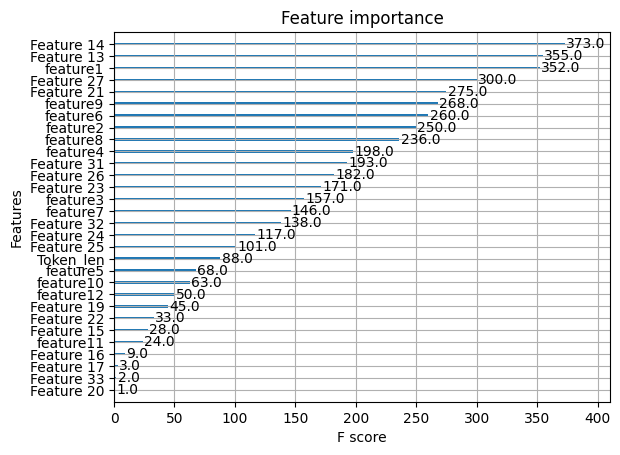

In [60]:
#XGBOOST - Feature Importance
plot_importance(XGBmodel)
pyplot.show()

RANDOM FOREST: 

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


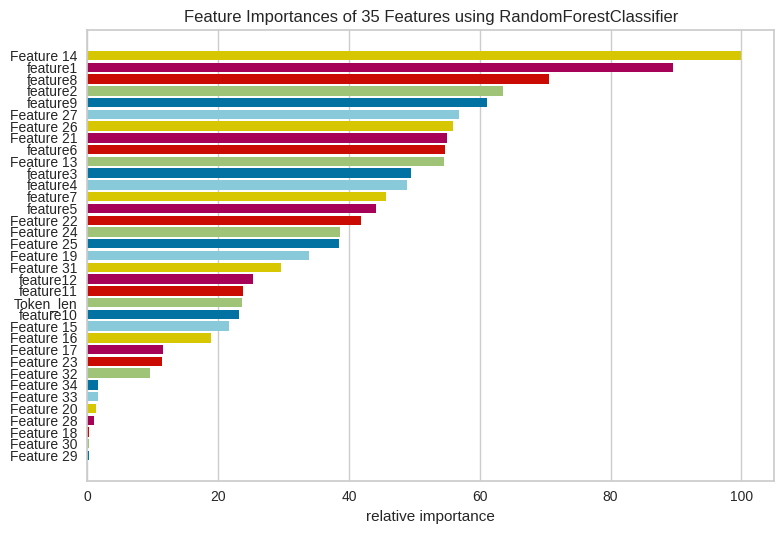

<Axes: title={'center': 'Feature Importances of 35 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [61]:
from yellowbrick.model_selection import FeatureImportances
viz = FeatureImportances(RFCmodel)
viz.fit(X, y)
viz.show()

# Correlation Dependent Feature Selection (CDFS)
1. Run correlation analysis and get a list of highly coordinated features (r-value > .60)
2. Run XGBoost Model with selected features
3. Run Random Forest classifier with selected features

##1. CDFS Setup

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
corr_matrix = X_train.corr(method='pearson')

In [63]:
len(corr_matrix)
n = np.square(len(corr_matrix))
top_pairs = (corr_matrix.abs().where(corr_matrix.abs() < 1).stack().nlargest(n).reset_index())
top_pairs = top_pairs.iloc[::2]
top_pairs = top_pairs.reset_index(drop=True)

In [64]:
top_pairs.head()

,level_0,level_1,0
0,Feature 25,Feature 24,0.984546
1,Token_len,feature10,0.961648
2,feature10,feature12,0.713541
3,Token_len,Feature 15,0.701296
4,feature11,Feature 25,0.689935


In [65]:
relevant_features = []
for i in range(0, len(top_pairs)):
  if top_pairs[0][i] >= .60:
    relevant_features.extend((top_pairs['level_0'][i], top_pairs['level_1'][i]))

relevant_features = list(set(relevant_features))

In [66]:
relevant_features

['Token_len',
 'Feature 15',
 'Feature 24',
 'feature12',
 'Feature 13',
 'Feature 25',
 'feature10',
 'feature11']

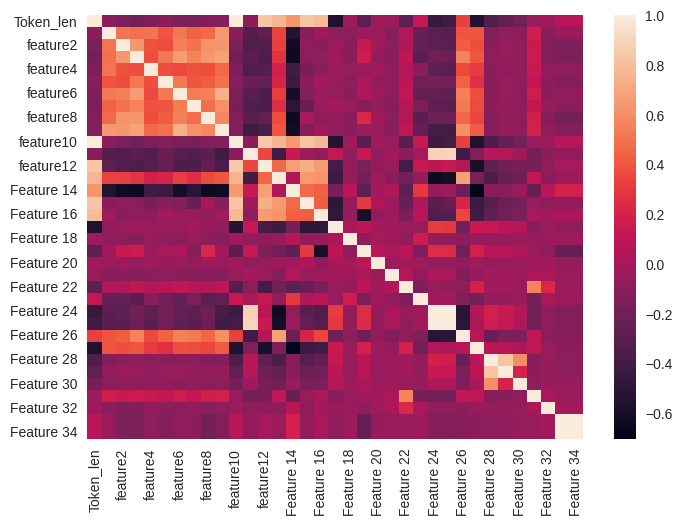

In [67]:
sns.heatmap(corr_matrix.corr());

## 2. CDFS on XGBoost

In [68]:
X_train_relevant = X_train[relevant_features]
X_test_relevant = X_test[relevant_features]

In [69]:
XGBmodel.fit(X_train_relevant, y_train)

y_pred = XGBmodel.predict(X_test_relevant)
CDFS_XGB_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", CDFS_XGB_accuracy)

Accuracy: 0.6513263023330137


## 3. CDFS on Random Forest

In [70]:
RFCmodel.fit(X_train_relevant, y_train)

y_pred = RFCmodel.predict(X_test_relevant)
CDFS_RFC_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", CDFS_RFC_accuracy)

Accuracy: 0.6869606903163951


# Forward Feature Selection (FFS)
We will do four things in this section. 
1. Implement FFS on the XGBoost Model
2. Implement FFS on the RandomForest Model
3. Aggregate a list of the feature selected from both FFS implementations
  - 3.1 Execute Random Forest and XGBoost classification w/ agrregated FFS features
  

## 1. Implement FFS with XGBoost

In [71]:
# Initialize selected features
XGB_selected_features = []

# Define evaluation function
def XGB_evaluate_model(X_train, X_test, y_train, y_test):
    XGBmodel.fit(X_train, y_train)
    y_pred = XGBmodel.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Implement forward feature selection
XGB_best_accuracy = 0
for feature in X_train.columns:
    current_features = XGB_selected_features + [feature]
    X_train_current = X_train[current_features]
    X_test_current = X_test[current_features]
    accuracy = XGB_evaluate_model(X_train_current, X_test_current, y_train, y_test)
    if accuracy > XGB_best_accuracy:
        XGB_best_accuracy = accuracy
        XGB_selected_features = current_features

In [72]:
XGB_base_accuracy = XGB_evaluate_model(X_train_current, X_test_current, y_train, y_test)

In [73]:
print(XGB_base_accuracy) # Base Model
print(XGB_best_accuracy) # XGBoost with best features from Forwared feature selection

0.663470757430489
0.6748162352189198


In [74]:
XGB_selected_features # XGBoost Features Selected from FFS

['Token_len', 'feature1', 'feature9', 'Feature 13', 'Feature 14']

## 2. Implement FFS with RandomForestClassifier

In [75]:
# Initialize selected features
RFC_selected_features = []

# Define evaluation function
def RFC_evaluate_model(X_train, X_test, y_train, y_test):
    RFCmodel.fit(X_train, y_train)
    y_pred = RFCmodel.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Implement forward feature selection
RFC_best_accuracy = 0
for feature in X_train.columns:
    current_features = RFC_selected_features + [feature]
    X_train_current = X_train[current_features]
    X_test_current = X_test[current_features]
    accuracy = RFC_evaluate_model(X_train_current, X_test_current, y_train, y_test)
    if accuracy > RFC_best_accuracy:
        RFC_best_accuracy = accuracy
        RFC_selected_features = current_features

In [76]:
RFC_base_accuracy = RFC_evaluate_model(X_train_current, X_test_current, y_train, y_test)

In [77]:
print(RFC_base_accuracy) #RFC Base Model
print(RFC_best_accuracy) #RFC with best features from FFS

0.7329817833173538
0.734100351550016


In [78]:
RFC_selected_features # Best features selected using FFS on Random Forest model

['Token_len',
 'Feature 13',
 'Feature 14',
 'Feature 18',
 'Feature 30',
 'Feature 31',
 'Feature 32']

## 3. Aggregate a list of the feature selected from both FFS implementations

In [79]:
#Aggregate lists of selected feature from both models
combined_feature_ls = XGB_selected_features + list(set(RFC_selected_features) - set(XGB_selected_features))

## 3.1 Execute Random Forest and XGBoost classification w/ agrregated FFS features

### Create a new dataframe
This dataframe will consist of feature columns that our forward feature selection process identified as the most useful.

In [80]:
combined_feature_ls.append('Label')
combined_fetures_df = df_allTrainTestVals[combined_feature_ls].copy()

In [81]:
combined_fetures_df

,Token_len,feature1,feature9,Feature 13,Feature 14,Feature 31,Feature 30,Feature 18,Feature 32,Label
0,11,1.42,-0.08,7.0,1.0,0.0,0.0,0.0,0.0,1
1,13,3.42,-0.14,8.0,3.0,0.0,0.0,0.0,0.0,1
2,12,2.38,-1.33,5.0,4.0,4.0,0.0,0.0,0.0,1
3,21,0.73,2.17,14.0,5.0,0.0,0.0,0.0,0.0,1
4,10,3.60,1.14,3.0,5.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
31284,9,-1.79,-7.22,2.0,7.0,0.0,0.0,0.0,0.0,0
31285,11,-1.34,7.51,5.0,5.0,0.0,0.0,0.0,0.0,1
31286,7,3.99,2.09,4.0,0.0,0.0,0.0,0.0,0.0,0
31287,9,0.20,1.48,3.0,5.0,0.0,0.0,0.0,0.0,0


### Train test split new DF

In [82]:
X_combined = combined_fetures_df.drop('Label', axis =1)
y_combined = combined_fetures_df['Label']

In [83]:
#Traintest split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, train_size=0.70, random_state=42, shuffle=True)

### XGBoost on aggregated feature set

In [84]:
XGBmodel.fit(X_train, y_train)
y_pred = XGBmodel.predict(X_test)
XGB_combined_accuracy = accuracy_score(y_test, y_pred)
print(XGB_combined_accuracy)

0.6760413337594545


### RFC on aggregated feature set

In [85]:
RFCmodel.fit(X_train, y_train)
y_pred = RFCmodel.predict(X_test)
RFC_combined_accuracy = accuracy_score(y_test, y_pred)
print(RFC_combined_accuracy)

0.7367636092468307


# Recursive Feature Elimination (RFE)
We will follow a similar workflow for Recursive Feature Elimination as we did for Forward Feature Selection

1. Implement RFE on the XGBoost model
  - 1.1 Execute XGBoost Classification w/ selected RFE features
2. Implement RFE on the Random Forest Classifier model
  - 2.1 Execute Random Forest Classification w/ selected RFE features
3. Agregate the list of selected fetures from both RFE implementations. 
  - 3.1 Execute Random Forest and XGBoost classification w/ agrregated RFE features

In [86]:
#Traintest split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42, shuffle=True)

## 1. Implement RFE on the XGBoost Model

In [87]:
#Model Definition
XGBmodel = XGBClassifier(scale_pos_weight=2.65,# 2.65; to train for imbalanced classification; nClass '0' / nClass '1' (here ~6.45)
                      learning_rate=0.01, #0.1 to 0.01
                      colsample_bytree = 0.3,#0.3 to 0.8 if many col (esp if ohe used); 0.8 to 1 if few columns
                      subsample = 0.8, #values 0.8 to 1
                      objective='binary:logistic',
                      n_estimators=300,#100 if data size high, 1000 if med-low
                      reg_alpha = 0.3, #appears to control pct of df used
                      max_depth=4,#start at 3, increase by 1
                      gamma=1)#Either 0, 1 or 5

eval_set = [(X_train, y_train), (X_test, y_test)]
XGBmodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [88]:
rfe = RFE(XGBmodel, n_features_to_select=12)
rfe.fit(X, y)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=0.3, early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=1, gpu_id=None,
                            grow_policy=None, importance_type=None,
                            interaction_constraints=None, learning_rate=0.01,
                            max_bin=None, max_cat_threshold=None,
                            max_cat_to_onehot=None, max_delta_step=None,
                            max_depth=4, max_leaves=None, min_child_weight=None,
                            missing=nan, monotone_constraints=None,
                            n_estimators=300, n_jobs=None,
                            num_parallel_tree=None, predictor=None,
                            random_state=None, ...),
    n_features_to_select=12)

In [89]:
feat_names = rfe.feature_names_in_
chosen_feats = rfe.support_

In [90]:
XGB_rfe_selected_features =[]
for i in range(0, len(feat_names)):
  if chosen_feats[i] == True:
    XGB_rfe_selected_features.append(feat_names[i])

In [91]:
XGB_rfe_selected_features

['feature1',
 'feature2',
 'feature8',
 'feature9',
 'feature12',
 'Feature 13',
 'Feature 14',
 'Feature 21',
 'Feature 23',
 'Feature 26',
 'Feature 27',
 'Feature 31']

## 2. Implement RFE on  Random Forest Model

In [92]:
RFCmodel = RandomForestClassifier(n_estimators=100, random_state=42)
RFCmodel.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [93]:
rfe = RFE(RFCmodel, n_features_to_select=12)
rfe.fit(X, y)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=12)

In [94]:
feat_names = rfe.feature_names_in_
chosen_feats = rfe.support_

In [95]:
RFC_rfe_selected_features = []
for i in range(0, len(feat_names)):
  if chosen_feats[i] == True:
    RFC_rfe_selected_features.append(feat_names[i])

In [96]:
RFC_rfe_selected_features

['feature1',
 'feature2',
 'feature3',
 'feature4',
 'feature6',
 'feature8',
 'feature9',
 'Feature 13',
 'Feature 14',
 'Feature 21',
 'Feature 26',
 'Feature 27']

## Features Selected by Each Model

In [97]:
print(f'The features selected by the RFE on the XGBoost Model were:{XGB_rfe_selected_features}')
print(f'The features selected by the RFE on the Random Forest Classifier Model were:{RFC_rfe_selected_features}')

The features selected by the RFE on the XGBoost Model were:['feature1', 'feature2', 'feature8', 'feature9', 'feature12', 'Feature 13', 'Feature 14', 'Feature 21', 'Feature 23', 'Feature 26', 'Feature 27', 'Feature 31']
The features selected by the RFE on the Random Forest Classifier Model were:['feature1', 'feature2', 'feature3', 'feature4', 'feature6', 'feature8', 'feature9', 'Feature 13', 'Feature 14', 'Feature 21', 'Feature 26', 'Feature 27']


## 1.1 Execute XGBOOST classification usinig RFE features

In [98]:
#Create Dataframe with feature columns selected for XGB with RFE
XGB_rfe_selected_features.append('Label')
RFE_XGB_fetures_df = df_allTrainTestVals[XGB_rfe_selected_features].copy()


In [99]:
#SET IINDEPENDENT & DEPENDENT VARIABLES
X_XGB_RFE = RFE_XGB_fetures_df.drop('Label', axis =1)
y_XGB_RFE = RFE_XGB_fetures_df['Label']

In [100]:
#Traintest split
X_train, X_test, y_train, y_test = train_test_split(X_XGB_RFE, y_XGB_RFE, train_size=0.70, random_state=42, shuffle=True)

In [101]:
XGBmodel.fit(X_train, y_train)
y_pred = XGBmodel.predict(X_test)
XGB_RFE_accuracy = accuracy_score(y_test, y_pred)
print(XGB_RFE_accuracy)

0.7045914562693086


## 2.1 Execute RANDOM FOREST Classification Using RFE Features

In [102]:
#Create Dataframe with feature columns selected for XGB with RFE
RFC_rfe_selected_features.append('Label')
RFE_RFC_fetures_df = df_allTrainTestVals[RFC_rfe_selected_features].copy()

In [103]:
#SET IINDEPENDENT & DEPENDENT VARIABLES
X_RFC_RFE = RFE_RFC_fetures_df.drop('Label', axis =1)
y_RFC_RFE = RFE_RFC_fetures_df['Label']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_RFC_RFE, y_RFC_RFE, train_size=0.70, random_state=42, shuffle=True)

In [105]:
RFCmodel.fit(X_train, y_train)
y_pred = RFCmodel.predict(X_test)
RFC_RFE_accuracy = accuracy_score(y_test, y_pred)
print(RFC_RFE_accuracy)

0.7621178225205071


## 3. Agregate the feature lists of both RFE Implementations
Like we did with Forward feature selection. We have taken all of features selected by the RFE XGBoost Model, and all of the features selected from the RFE Random Forest Model and combined the two. 

In [106]:
#Combine lists -Combine features selected by both RFE modles
rfe_combined_feature_ls = XGB_rfe_selected_features + list(set(RFC_rfe_selected_features) - set(XGB_rfe_selected_features))

## 3.1 Execute Random Forest and XGBoost classification w/ agrregated RFE features

In [107]:
# df of combined features from both RFE methods
rfe_combined_fetures_df = df_allTrainTestVals[rfe_combined_feature_ls].copy()

In [108]:
# X and y for RFE combined features 
X_RFE_combined = rfe_combined_fetures_df.drop('Label', axis =1)
y_RFE_combined = rfe_combined_fetures_df['Label']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_RFE_combined, y_RFE_combined, train_size=0.70, random_state=42, shuffle=True)

In [110]:
XGBmodel.fit(X_train, y_train)
y_pred = XGBmodel.predict(X_test)
RFE_XGB_combined_accuracy = accuracy_score(y_test, y_pred)
print(RFE_XGB_combined_accuracy)

0.7062959411952701


In [111]:
RFCmodel.fit(X_train, y_train)
y_pred = RFCmodel.predict(X_test)
RFE_RFC_combined_accuracy = accuracy_score(y_test, y_pred)
print(RFE_RFC_combined_accuracy)

0.7643549589858315


# Compare Accuracy Metrics
Bar chart comparison of all models

In [112]:
# creating visualization Dataset
data = {'Base XGBoost ':XGB_base_accuracy,
        'Base Random Forest ':RFC_base_accuracy,
        'CDFS: XGBoost ': CDFS_XGB_accuracy,
        'CDFS: Random Forest ': CDFS_RFC_accuracy, 
        'FFS: XGBoost ': XGB_best_accuracy, 
        'FFS: Random Forest ':RFC_best_accuracy,
        'FFS: Combined XGBoost ': XGB_combined_accuracy,
        'FFS: Combined Random Forest ':RFC_combined_accuracy,
        'RFE: XGB ':XGB_RFE_accuracy,
        'RFE: Random Forest': RFC_RFE_accuracy,
        'RFE: Combined XGBoost ':RFE_XGB_combined_accuracy,
        'RFE: Combined Random Forest ':RFE_RFC_combined_accuracy}

In [113]:
import plotly.graph_objects as go
import plotly.express as px


data_names = list(data.keys())
data_quantities = list(data.values())
data_quantities = [ round(x*100,1) for x in data_quantities]

colors = px.colors.qualitative.Dark24

fig = go.Figure(data=[go.Bar(x=data_names, y=data_quantities, marker_color=colors, text=data_quantities, textposition='outside', textangle=0)])

fig.update_layout(title='Model Accuracies', xaxis_title='Model', yaxis_title='Accuracy', yaxis=dict(range=[0,85]))

fig.show()

# What This Tells Us

From the graph above we can see that the set of features that yeild the highest results classification accuracy come from the Recursive Feature Elimination method, particularly when used with the random forest classifier. We will now take a deeper look at these specific features

Feature Importances of Random Forest Classifier model w/ aggregated features

In [114]:
RFC_rfe_selected_features_temp = RFC_rfe_selected_features

In [115]:
RFC_rfe_selected_features_df = df_allTrainTestVals[RFC_rfe_selected_features].copy()

In [116]:
X_RFC_RFE = RFC_rfe_selected_features_df.drop('Label', axis =1)
y_RFC_RFE = RFC_rfe_selected_features_df['Label']

In [117]:
rfe.fit(X_RFC_RFE, y_RFC_RFE)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=12)

In [119]:
RFCmodel.fit(X_RFC_RFE, y_RFC_RFE)

RandomForestClassifier(random_state=42)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



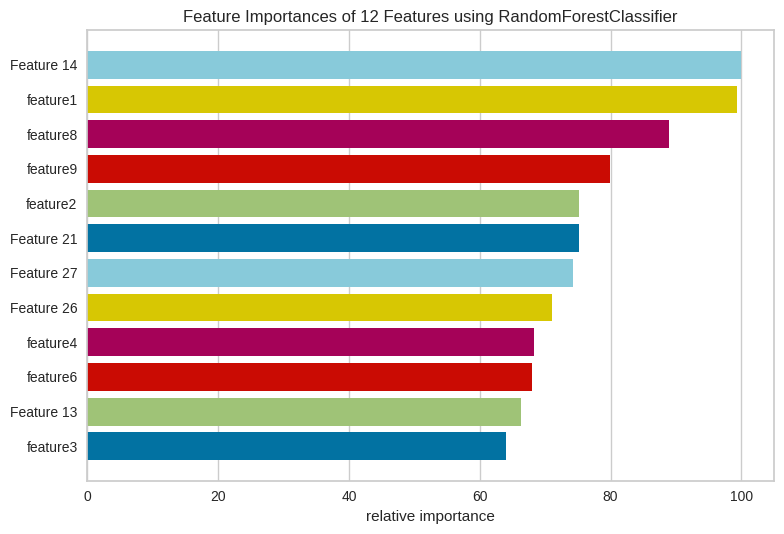

<Axes: title={'center': 'Feature Importances of 12 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [120]:
viz = FeatureImportances(RFCmodel)
viz.fit(X_RFC_RFE, y_RFC_RFE)
viz.show()

NEW FEATURE IMPORTANCES - Feature Importances of XGBoost Classifier model w/ aggregated features

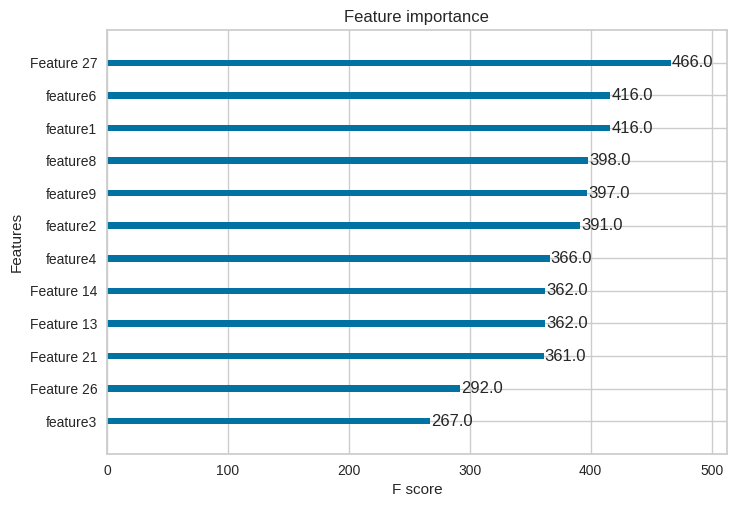

In [121]:
#XGBOOST - Feature Importances on Aggregates Feature List
XGBmodel.fit(X_RFC_RFE, y_RFC_RFE) 
plot_importance(XGBmodel)
pyplot.show()

PARTIAL DEPENDENCE PLOT on Random Forest Classifier w/ Aggregated Features


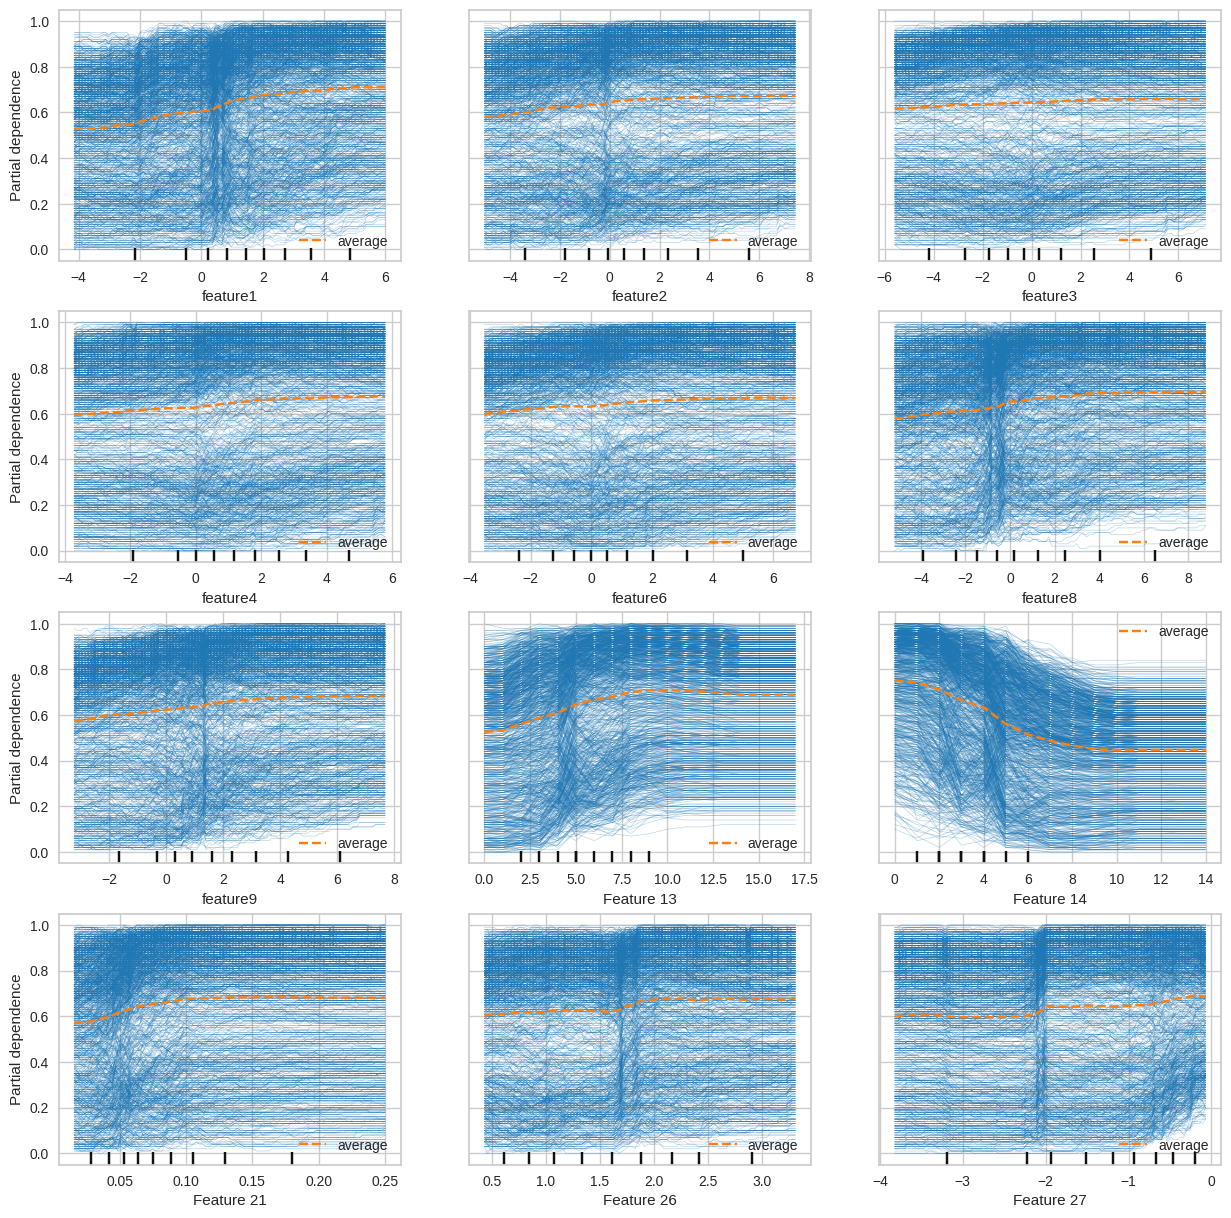

In [122]:
features = [0,1,2,3,4,5,6,7,8,9,10,11]
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
PartialDependenceDisplay.from_estimator(RFCmodel, X_RFC_RFE,features, kind='both', ax=axes, subsample=1000)



PARALLEL COORDINATES

In this plot, each input row is represented by one line. The color of the line represents the classification 0 or 1. each row input (line) shows its value at each feature. THis allows us to see patterns in feature values for different classifications. 

In [123]:
#Sample the dataframe so we can see patterns better
sampled_df = RFC_rfe_selected_features_df.sample(frac=0.03, replace=True, random_state=1)

In [124]:
del RFC_rfe_selected_features_temp[-1]

In [125]:
fig = px.parallel_coordinates(sampled_df, color="Label",
                              dimensions=RFC_rfe_selected_features_temp)
fig.show()

# Logistic Regression from Scratch
With our list of aggregated features that produced the best results in the previous models, we will run logistic regression from scratch using the same features

In [126]:
class LogRegression:
    def __init__(self, feature_number, lr, epochs):      
        self.intercept = 0
        self.weight = np.zeros(feature_number)
        self.lr = lr
        self.epochs = epochs


    def sigmoid(self, X):
        z = np.dot(X, self.weight) + self.intercept
        return 1 / (1 + np.exp(-z))
    
    def loss(self, s, y):
        return (-y * np.log(s) - (1 - y) * np.log(1 - s)).mean()
    
    def gradient_descent(self, X, s, y):
        return np.dot(X.T, (s - y)) / y.shape[0]
    
    def gradient_descent_intercept(self, s, y):
        return np.mean(s - y)

    def fit(self, X, y):
        losses = []
        for i in range(self.epochs):
            sigma = self.sigmoid(X)

            dW = self.gradient_descent(X , sigma, y)
            dintercept = self.gradient_descent_intercept(sigma, y)

            self.weight -= self.lr * dW
            self.intercept -= self.lr * dintercept

            loss = self.loss(sigma, y)
            if len(losses) % 1000 == 0:
                print("The iteration is " + str(i) + " and the loss is " +  str(loss))
            losses.append(loss)
            if i > 1000:
              if losses[-1] > losses[-100] - .0001:     #the difference should be an argument
                print("The weight is ")
                print(self.weight)
                print("The intercept is ")
                print(self.intercept)
                break
        return losses
    
    def predict(self, train):
        x_new = train
        result = self.sigmoid(x_new)
        y_pred = np.zeros(result.shape[0])
        for i in range(len(y_pred)):
            if result[i] >= 0.5: 
                y_pred[i] = 1
            else:
                y_pred[i] = 0
                continue
                
        return y_pred
      
    def metrics(self, pred, test):
        y_pred=pred
        y_test=test
        tp=(sum((y_pred == 1) & (y_test==1)))
        fp=(sum((y_pred == 1) & (y_test==0)))
        fn=(sum((y_pred == 0) & (y_test==1)))
        tn=(sum((y_pred == 0) & (y_test==0)))
        confusion_matrix=[[tn, fp], [fn, tp]]
        f1 = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fn))+(tp/(tp+fp)))
        print("The confusion matrix is: ")
        print(confusion_matrix[0])
        print(confusion_matrix[1])
        print('The accuracy for the Twitter sentiment is {}'.format(sum(y_pred == y_test) / y_test.shape[0]))
        print('The precision for the Twitter sentiment is {}'.format((tp/(tp+fp))))
        print('The recall for the Twitter sentiment is {}'.format((tp/(tp+fn))))
        print('The F1 score for the Twitter sentiment is {}'.format((2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fn))+(tp/(tp+fp))))))
        return confusion_matrix


    def f1_score(self, pred, test):
      y_pred=pred
      y_test=test
      tp=(sum((y_pred == 1) & (y_test==1)))
      fp=(sum((y_pred == 1) & (y_test==0)))
      fn=(sum((y_pred == 0) & (y_test==1)))
      tn=(sum((y_pred == 0) & (y_test==0)))
      f1 = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fn))+(tp/(tp+fp)))
      return f1


    def fit_no_output(self, X, y):
        losses = []
        for i in range(self.epochs):
            sigma = self.sigmoid(X)
            dW = self.gradient_descent(X , sigma, y)
            dintercept = self.gradient_descent_intercept(sigma, y)
            self.weight -= self.lr * dW
            self.intercept -= self.lr * dintercept
            loss = self.loss(sigma, y)
            if i > 1000:
              if losses[-1] > losses[-100] - .0001:     #the difference should be an argument
                break
            losses.append(loss)    
        return losses

        

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X_RFC_RFE, y_RFC_RFE, test_size=0.3, random_state=42)
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [128]:
feature_number, lr, epochs = X_train.shape[1], .5, 1000000
LogRegSent = LogRegression(feature_number, lr, epochs)
losses = LogRegSent.fit(X_train_norm, y_train)

The iteration is 0 and the loss is 0.6931471805599453
The iteration is 1000 and the loss is 0.5183057063474152
The iteration is 2000 and the loss is 0.5132268168630175
The iteration is 3000 and the loss is 0.5105249392310959
The iteration is 4000 and the loss is 0.5086460960590639
The iteration is 5000 and the loss is 0.5072971331886937
The weight is 
[ 3.92868822  1.32756814  0.19296866  0.18165478  1.31091799  1.82565354
  1.3367522   2.96332002 -4.69306272 -0.04300429  1.28430831  1.17922409]
The intercept is 
-5.757903781742651


<function matplotlib.pyplot.show(close=None, block=None)>

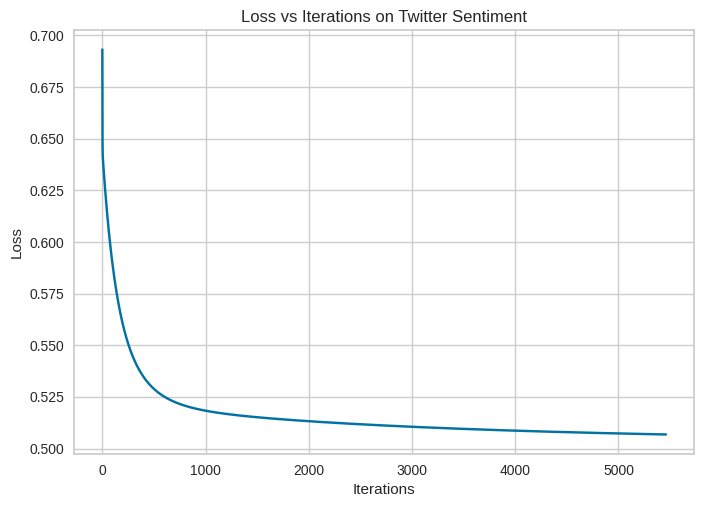

In [129]:
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations on Twitter Sentiment")
plt.plot(losses)
plt.show

In [130]:
y_pred = LogRegSent.predict(X_test_norm)

In [131]:
cm = LogRegSent.metrics(y_pred, y_test)

The confusion matrix is: 
[1718, 1563]
[764, 5342]
The accuracy for the Twitter sentiment is 0.7521039735804836
The precision for the Twitter sentiment is 0.7736422881969587
The recall for the Twitter sentiment is 0.8748771699967245
The F1 score for the Twitter sentiment is 0.8211513334870494


In [132]:
our_accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])

# Compare Our Logistic Regression Against SKlearn


In [133]:
LogReg_model = LogisticRegression(max_iter=100000)
LogReg_model.fit(X_RFC_RFE, y_RFC_RFE)

LogisticRegression(max_iter=100000)

In [134]:
LogReg_model.fit(X_train, y_train)
y_pred = LogReg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [135]:
print(f'Our Logistic Regression from scratch achieved an accuracy of {our_accuracy:.2%}!')
print(f'Sklearn logistic regression had an accuracy of {accuracy:.2%}!')

Our Logistic Regression from scratch achieved an accuracy of 75.21%!
Sklearn logistic regression had an accuracy of 75.52%!


# How Does It Stack Up To the Other Classifiers?

In [136]:
# creating visualization Dataset
data = {'Base XGBoost Model':XGB_base_accuracy,
        'Base Random Forest Model':RFC_base_accuracy,
        'CDFS: XGBoost ': CDFS_XGB_accuracy,
        'CDFS: Random Forest ': CDFS_RFC_accuracy, 
        'FFS: XGBoost Model':XGB_best_accuracy, 
        'FFS: Random Forest Model':RFC_best_accuracy,
        'FFS: Combined XGBoost Model': XGB_combined_accuracy,
        'FFS: Combined Random Forest Model':RFC_combined_accuracy,
        'RFE: XGB Model':XGB_RFE_accuracy,
        'RFE: Random Forest': RFC_RFE_accuracy,
        'RFE: Combined XGBoost Model':RFE_XGB_combined_accuracy,
        'RFE: Combined Random Forest Model':RFE_RFC_combined_accuracy,
        'Logistic Regression From Scratch': our_accuracy,
        'Logistic Regression - SKLearn': accuracy}

In [137]:
data_names = list(data.keys())
data_quantities = list(data.values())
data_quantities = [ round(x*100,1) for x in data_quantities]

colors = px.colors.qualitative.Dark24

fig = go.Figure(data=[go.Bar(x=data_names, y=data_quantities, marker_color=colors, text=data_quantities, textposition='outside', textangle=0)])

fig.update_layout(title='Model Accuracies', xaxis_title='Model', yaxis_title='Accuracy', yaxis=dict(range=[0,85]))

fig.show()

## Drawing conclusions

This info tells us that the most useful set of features comes from the sudo transfer learning version of recursive feature analysis. The features are most effectivley used in a Random classifier model. but are also vey effective in a logistic regression


# Remove 1 feature
We want to try our own method of feature analysis on this logistic regression also. In this section we are going to start with a model that has all of the original features but we will iterativley remove 1 feature. If the removal of that feature improves the f1 score of the model, then we will remove that feature from useage. If the removal has degrades the model then we will keep the feature in useage.

In [138]:
#define evaluation function
def model_eval(X_train, X_test, y_train, y_test):
  mms = MinMaxScaler()
  X_train_normalized = mms.fit_transform(X_train)
  X_test_normalized = mms.transform(X_test)

  feature_number, lr, epochs = X_train.shape[1], .5, 1000000
  LogRegSent = LogRegression(feature_number, lr, epochs)
  losses = LogRegSent.fit_no_output(X_train_normalized, y_train)

  y_pred = LogRegSent.predict(X_test_normalized)
  f1 = LogRegSent.f1_score(y_pred, y_test)
  return f1

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
score = model_eval(X_train, X_test, y_train, y_test)
best_f1 = score
all_feats = list(df_allTrainTestVals.iloc[:, 4:].columns) 
base_feats = list(df_allTrainTestVals.iloc[:, 4:].columns) # index

X = df_allTrainTestVals.iloc[:, 4:] # Dependent variables - All values from token length (index 4) to the end of the dataframe
y = df_allTrainTestVals['Label'] # Independent Variable 


In [141]:
for i in range(0,len(base_feats)):
  #Establish model 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  f1 = model_eval(X_train, X_test, y_train, y_test)
  best_f1 = f1
  print(f'The current f1 score is: {best_f1}')
  print(f'All available features for this iteration are: {list(X.columns)}')
  print('')

  #Delete value from list list of features being activley used not index list 
  print(f'Drop {base_feats[i]}')
  all_feats.remove(base_feats[i])

  #Print which value has been deleted
  print(f'{base_feats[i]} has been dropped!') 
  print('')

  #X_branch is a data frame created from the features that are remaining after one has been removed
  X_branch = X[all_feats].copy()
  print(f'The remaining features are {list(X_branch.columns)}')
  print('')

  # Calculate the new f1 with the removed value - Here we use X_branch 
  print(f'Calculating the f1 with {base_feats[i]} removed')
  X_train, X_test, y_train, y_test = train_test_split(X_branch, y, test_size=0.2, random_state=42) #used x branch as the dependent value because it is now edidted to have the features we want
  f1 = model_eval(X_train, X_test, y_train, y_test)
  
  print(f'The f1 of the model with the removed feature is {f1}')


  if f1 > best_f1:
    best_f1 = f1
    print(f'{best_f1} is an improvment! ')
    print(f'Permanently dropping {base_feats[i]}')
    # Permenantly drop that feature from the being used
    X = X.drop(base_feats[i], axis = 1)
    print(f'{base_feats[i]} sas been permenately dropped and will no longer be considered')
    

  elif f1 <= best_f1:
    print(f'{f1} is not an improvement in f1 score')
    print(f'{base_feats[i]} will remain in the feature set ')
    all_feats.insert(i, base_feats[i])


  print('')
  print('------------------------------------------------------------------------------------------------')
  print('------------------------------------------------------------------------------------------------')



The current f1 score is: 0.8293871866295265
All available features for this iteration are: ['Token_len', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'Feature 13', 'Feature 14', 'Feature 15', 'Feature 16', 'Feature 17', 'Feature 18', 'Feature 19', 'Feature 20', 'Feature 21', 'Feature 22', 'Feature 23', 'Feature 24', 'Feature 25', 'Feature 26', 'Feature 27', 'Feature 28', 'Feature 29', 'Feature 30', 'Feature 31', 'Feature 32', 'Feature 33', 'Feature 34']

Drop Token_len
Token_len has been dropped!

The remaining features are ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'Feature 13', 'Feature 14', 'Feature 15', 'Feature 16', 'Feature 17', 'Feature 18', 'Feature 19', 'Feature 20', 'Feature 21', 'Feature 22', 'Feature 23', 'Feature 24', 'Feature 25', 'Feature 26', 'Feature 27', 'Feature 2

In [142]:
temp3 = []
for element in base_feats:
    if element not in all_feats:
        temp3.append(element)
 
print(f'The features that were removed, that improved f1 score are: {temp3}')

The features that were removed, that improved f1 score are: ['feature5', 'feature7', 'feature10']


# Add 1 Feature
We will be doing the inverse of the last section here. We are going to start with set of features that we identified as most beneficial for improving accuracy. In each iteration we will add 1 feature to see if the f1 score of our logistic regression from scratch, improves.

In [143]:
X = df_allTrainTestVals.iloc[:, 4:] # Dependent variables - All values from token length (index 4) to the end of the dataframe
y = df_allTrainTestVals['Label'] # Independent Variable 

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X_RFC_RFE, y_RFC_RFE, test_size=0.2, random_state=42)
score = model_eval(X_train, X_test, y_train, y_test)
best_f1 = score

all_feats = list(df_allTrainTestVals.iloc[:, 4:].columns)
base_feats = RFC_rfe_selected_features_temp

In [145]:
best_f1 = score
all_feats = list(df_allTrainTestVals.iloc[:, 4:].columns)
base_feats = RFC_rfe_selected_features_temp

In [146]:
for i in range(0, len(base_feats)):
  all_feats.remove(base_feats[i])

In [147]:
for i in range(0,len(all_feats)):
  #Establish model 
  X_train, X_test, y_train, y_test = train_test_split(X_RFC_RFE, y_RFC_RFE, test_size=0.2, random_state=42)
  f1 = model_eval(X_train, X_test, y_train, y_test)
  best_f1 = f1
  print(f'The current faeture array is {list(X_RFC_RFE.columns)}')
  print(f'The current f1 score is: {best_f1}')
  print('')

  #Add 1 feature column to the set that we already have and test get results
  print(f'Adding {all_feats[i]} to current feature array')
  desired_column = X[all_feats[i]]
  X_branch = X_RFC_RFE.join(desired_column)
  print('Added')
  print(f'New feature array is{list(X_branch.columns)}')
  print('')

  #Get f1 value with new feature column added
  print(f'Calculating f1 with new feature {all_feats[i]} added')
  X_train, X_test, y_train, y_test = train_test_split(X_branch, y_RFC_RFE, test_size=0.2, random_state=42) #used x branch as the dependent value because it is now edidted to have the features we want
  f1 = model_eval(X_train, X_test, y_train, y_test)
  print(f'The f1 including new feature {all_feats[i]} is {f1}')
  print('')

  #Decision
  if f1 > best_f1:
    best_f1 = f1
    print(f'{best_f1} is an improvment! ')
    print(f'{all_feats[i]} will be added to the feature array and used for following comparisons')
    X_RFC_RFE = X_RFC_RFE.join(desired_column)
    print('')
    print(f'The new permanent feature vector is {list(X_RFC_RFE.columns)}')

  elif f1 <= best_f1:
    print(f'{f1} is not an improvement in f1 score')
    print(f'{all_feats[i]} will not be held in the feature array ')
    print('')
    print(f'The feature vector remains {list(X_RFC_RFE.columns)}')
    
    
  print('')
  print('------------------------------------------------------------------------------------------------')
  print('------------------------------------------------------------------------------------------------')


The current faeture array is ['feature1', 'feature2', 'feature3', 'feature4', 'feature6', 'feature8', 'feature9', 'Feature 13', 'Feature 14', 'Feature 21', 'Feature 26', 'Feature 27']
The current f1 score is: 0.8232183908045977

Adding Token_len to current feature array
Added
New feature array is['feature1', 'feature2', 'feature3', 'feature4', 'feature6', 'feature8', 'feature9', 'Feature 13', 'Feature 14', 'Feature 21', 'Feature 26', 'Feature 27', 'Token_len']

Calculating f1 with new feature Token_len added
The f1 including new feature Token_len is 0.8240974936767075

0.8240974936767075 is an improvment! 
Token_len will be added to the feature array and used for following comparisons

The new permanent feature vector is ['feature1', 'feature2', 'feature3', 'feature4', 'feature6', 'feature8', 'feature9', 'Feature 13', 'Feature 14', 'Feature 21', 'Feature 26', 'Feature 27', 'Token_len']

------------------------------------------------------------------------------------------------
---

In [148]:
temp3 = []
for element in list(X_combined.columns):
    if element not in base_feats:
        temp3.append(element)
 
print(f'The features that were removed, that improved f1 score are: {temp3}')
print('')
print(f'The ending feature vector producing the highest f1 is {list(X_combined.columns)}')

The features that were removed, that improved f1 score are: ['Token_len', 'Feature 31', 'Feature 30', 'Feature 18', 'Feature 32']

The ending feature vector producing the highest f1 is ['Token_len', 'feature1', 'feature9', 'Feature 13', 'Feature 14', 'Feature 31', 'Feature 30', 'Feature 18', 'Feature 32']
